In [ ]:
# %pip install -U lightgbm==3.3.2

In [1]:
import sys
from google.colab import drive
drive.mount('/content/gdrive')
sys.path.append('/content/gdrive/MyDrive/H-M-Fashion-RecSys')
import os
os.chdir('/content/gdrive/MyDrive/H-M-Fashion-RecSys/notebooks')

import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb

import pickle
from tqdm import tqdm
import gc
from pathlib import Path

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import warnings
import sys
from IPython.core.interactiveshell import InteractiveShell

warnings.filterwarnings("ignore")
sys.path.append("../") # path to the `src`` folder
InteractiveShell.ast_node_interactivity = "all"
tqdm.pandas()

In [3]:
from src.data import DataHelper
from src.data.metrics import map_at_k, hr_at_k, recall_at_k
!pip install implicit
from src.retrieval.rules import (
    OrderHistory,
    OrderHistoryDecay,
    ItemPair,

    UserGroupTimeHistory,
    UserGroupSaleTrend,

    TimeHistory,
    TimeHistoryDecay,
    SaleTrend,

    OutOfStock,
)
from src.retrieval.collector import RuleCollector

from src.features import cum_sale, week_sale, repurchase_ratio, purchased_before, popularity

from src.utils import calc_valid_date, merge_week_data, reduce_mem_usage


In [4]:
data_dir = Path("../src/data/")

In [5]:
TRAIN_WEEK_NUM = 4
WEEK_NUM = TRAIN_WEEK_NUM + 2
VERSION_NAME = "pivot"# "v1"

In [6]:
import os
if not os.path.exists(data_dir/"interim"/VERSION_NAME):
    os.mkdir(data_dir/"interim"/VERSION_NAME)

In [7]:
TEST = False # * Set as `False` when do local experiments to save time

Pepare data: encoding ids and preprocessing

In [8]:
dh = DataHelper(data_dir)

In [9]:
#data = dh.preprocess_data(save=True, name="encoded_full") # * run only once, processed data will be saved

In [10]:
data = dh.load_data(name="encoded_full")

In [11]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

## Retrieval


Generate candidates for each week

In [ ]:
listBin = [-1, 19, 29, 39, 49, 59, 69, 119]
data['user']['age_bins'] = pd.cut(data['user']['age'], listBin)

In [ ]:
data['user']['age_bucket'] = pd.cut(data['user']['age'].fillna(22), [15, 24, 35, 50, 100], labels=[0, 1, 2, 3])

In [ ]:
# * WEEK_NUM = 0: test
# * WEEK_NUM = 1: valid
# * WEEK_NUM > 1: train

for week in range(1, WEEK_NUM):
    # * use sliding window to generate candidates
    if week == 0 and not TEST:
        continue
    trans = data["inter"]

    start_date, end_date = calc_valid_date(week)
    print(f"Week {week}: [{start_date}, {end_date})")
    
    last_week_start = pd.to_datetime(start_date) - pd.Timedelta(days=7)
    last_week_start = last_week_start.strftime("%Y-%m-%d")
    
    last_3day_start = pd.to_datetime(start_date) - pd.Timedelta(days=3)
    last_3day_start = last_3day_start.strftime("%Y-%m-%d")

    train, valid = dh.split_data(trans, start_date, end_date)

    last_week = train.loc[train.t_dat >= last_week_start]
    last_week = last_week.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')
    
    last_3days = train.loc[train.t_dat >= last_3day_start]
    last_3days = last_3days.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')
    
    train = train.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')

    if week != 0:
        customer_list = valid["customer_id"].values
    else:
        customer_list = submission['customer_id'].values

    # * ========================== Retrieval Strategies ==========================

    candidates = RuleCollector().collect(
        week_num = week,
        trans_df = trans,
        customer_list=customer_list,
        rules=[
            OrderHistory(train, 3),
            OrderHistory(train, 7),
            OrderHistoryDecay(train, 3, n=50),
            OrderHistoryDecay(train, 7, n=50),
            ItemPair(OrderHistory(train, 3).retrieve(), name='1'),
            ItemPair(OrderHistory(train, 7).retrieve(), name='2'),
            ItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),
            ItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),
            UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50, name='1'),
            UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50, name='2'),
            UserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=50),
            TimeHistory(customer_list, last_week, n=50, name='1'),
            TimeHistory(customer_list, last_3days, n=50, name='2'),
            TimeHistoryDecay(customer_list, train, 3, n=50),
            TimeHistoryDecay(customer_list, train, 7, n=50),
            SaleTrend(customer_list, train, 7, n=50),
        ],
        filters=[OutOfStock(trans)],
        min_pos_rate=0.005,
        compress=False,
    )
    
    candidates = (
        pd.pivot_table(
            candidates,
            values="score",
            index=["customer_id", "article_id"],
            columns=["method"],
            aggfunc=np.sum,
        )
        .reset_index()
        # .fillna(0)
    )

    candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
    if WEEK_NUM != 0:
        valid.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_label.pqt")

Week 1: [2020-09-16, 2020-09-23)


Retrieve items by rules:   6%|▋         | 1/16 [00:19<04:55, 19.68s/it]

Positive rate: 0.03038


Retrieve items by rules:  12%|█▎        | 2/16 [00:39<04:35, 19.65s/it]

Positive rate: 0.02859


Retrieve items by rules:  19%|█▉        | 3/16 [01:29<07:17, 33.69s/it]

Positive rate: 0.01413
Positive rate: 0.01295


Retrieve items by rules:  25%|██▌       | 4/16 [02:22<08:12, 41.04s/it]

Positive rate: 0.01519


Retrieve items by rules:  31%|███▏      | 5/16 [02:39<05:57, 32.54s/it]

Positive rate: 0.01472


Retrieve items by rules:  38%|███▊      | 6/16 [02:58<04:40, 28.01s/it]

Positive rate: 0.00908


Retrieve items by rules:  44%|████▍     | 7/16 [03:29<04:21, 29.05s/it]

Positive rate: 0.00853


Retrieve items by rules:  50%|█████     | 8/16 [04:11<04:23, 32.95s/it]

TOP35.0 Positive rate: 0.00501


Retrieve items by rules:  56%|█████▋    | 9/16 [04:17<02:51, 24.57s/it]

TOP38.5 Positive rate: 0.00508


Retrieve items by rules:  62%|██████▎   | 10/16 [04:22<01:52, 18.68s/it]

TOP3.0 Positive rate: 0.00542


Retrieve items by rules:  69%|██████▉   | 11/16 [04:35<01:23, 16.73s/it]

TOP25.0 Positive rate: 0.00503


Retrieve items by rules:  75%|███████▌  | 12/16 [04:40<00:53, 13.26s/it]

TOP30.0 Positive rate: 0.00505


Retrieve items by rules:  81%|████████▏ | 13/16 [04:45<00:32, 10.78s/it]

TOP31.0 Positive rate: 0.00503


Retrieve items by rules:  88%|████████▊ | 14/16 [05:15<00:33, 16.65s/it]

TOP24.0 Positive rate: 0.00506


Retrieve items by rules:  94%|█████████▍| 15/16 [05:47<00:21, 21.07s/it]

TOP4.0 Positive rate: 0.00568


Retrieve items by rules: 100%|██████████| 16/16 [05:58<00:00, 22.43s/it]


Week 2: [2020-09-09, 2020-09-16)


Retrieve items by rules:   6%|▋         | 1/16 [00:20<05:02, 20.15s/it]

Positive rate: 0.03008


Retrieve items by rules:  12%|█▎        | 2/16 [00:40<04:46, 20.49s/it]

Positive rate: 0.02825


Retrieve items by rules:  19%|█▉        | 3/16 [01:36<07:56, 36.65s/it]

Positive rate: 0.01354


Retrieve items by rules:  25%|██▌       | 4/16 [02:30<08:41, 43.45s/it]

Positive rate: 0.01244
Positive rate: 0.01435


Retrieve items by rules:  31%|███▏      | 5/16 [02:48<06:16, 34.26s/it]

Positive rate: 0.01376


Retrieve items by rules:  38%|███▊      | 6/16 [03:08<04:53, 29.40s/it]

Positive rate: 0.00886


Retrieve items by rules:  44%|████▍     | 7/16 [03:42<04:37, 30.88s/it]

Positive rate: 0.00830


Retrieve items by rules:  50%|█████     | 8/16 [04:29<04:48, 36.11s/it]

TOP21.0 Positive rate: 0.00501


Retrieve items by rules:  56%|█████▋    | 9/16 [04:36<03:08, 26.97s/it]

TOP11.0 Positive rate: 0.00515


Retrieve items by rules:  69%|██████▉   | 11/16 [04:54<01:29, 17.94s/it]

skip
TOP13.0 Positive rate: 0.00502


Retrieve items by rules:  75%|███████▌  | 12/16 [05:00<00:56, 14.18s/it]

TOP6.0 Positive rate: 0.00544


Retrieve items by rules:  81%|████████▏ | 13/16 [05:06<00:34, 11.61s/it]

TOP11.0 Positive rate: 0.00500


Retrieve items by rules:  88%|████████▊ | 14/16 [05:35<00:33, 16.84s/it]

TOP11.0 Positive rate: 0.00517


Retrieve items by rules: 100%|██████████| 16/16 [06:12<00:00, 23.29s/it]

skip


Week 3: [2020-09-02, 2020-09-09)


Retrieve items by rules:   6%|▋         | 1/16 [00:19<04:52, 19.51s/it]

Positive rate: 0.02822


Retrieve items by rules:  12%|█▎        | 2/16 [00:39<04:35, 19.68s/it]

Positive rate: 0.02679


Retrieve items by rules:  19%|█▉        | 3/16 [01:31<07:31, 34.73s/it]

Positive rate: 0.01321


Retrieve items by rules:  25%|██▌       | 4/16 [02:25<08:23, 41.99s/it]

Positive rate: 0.01237
Positive rate: 0.01490


Retrieve items by rules:  31%|███▏      | 5/16 [02:43<06:09, 33.56s/it]

Positive rate: 0.01435


Retrieve items by rules:  38%|███▊      | 6/16 [03:04<04:51, 29.15s/it]

Positive rate: 0.00910


Retrieve items by rules:  44%|████▍     | 7/16 [03:48<05:06, 34.08s/it]

Positive rate: 0.00873


Retrieve items by rules:  50%|█████     | 8/16 [04:46<05:33, 41.73s/it]

TOP31.0 Positive rate: 0.00502


Retrieve items by rules:  56%|█████▋    | 9/16 [04:53<03:35, 30.82s/it]

TOP29.5 Positive rate: 0.00505


Retrieve items by rules:  69%|██████▉   | 11/16 [05:12<01:40, 20.07s/it]

skip
TOP20.0 Positive rate: 0.00501


Retrieve items by rules:  75%|███████▌  | 12/16 [05:18<01:02, 15.72s/it]

TOP17.0 Positive rate: 0.00519


Retrieve items by rules:  81%|████████▏ | 13/16 [05:24<00:38, 12.73s/it]

TOP17.0 Positive rate: 0.00515


Retrieve items by rules:  88%|████████▊ | 14/16 [05:53<00:35, 17.85s/it]

TOP18.0 Positive rate: 0.00522


Retrieve items by rules: 100%|██████████| 16/16 [06:32<00:00, 24.56s/it]

skip


Week 4: [2020-08-26, 2020-09-02)


Retrieve items by rules:   6%|▋         | 1/16 [00:19<04:56, 19.79s/it]

Positive rate: 0.02406


Retrieve items by rules:  12%|█▎        | 2/16 [00:40<04:40, 20.04s/it]

Positive rate: 0.02268


Retrieve items by rules:  19%|█▉        | 3/16 [01:34<07:42, 35.56s/it]

Positive rate: 0.01182


Retrieve items by rules:  25%|██▌       | 4/16 [02:27<08:31, 42.65s/it]

Positive rate: 0.01123
Positive rate: 0.01353


Retrieve items by rules:  31%|███▏      | 5/16 [02:46<06:13, 33.93s/it]

Positive rate: 0.01306


Retrieve items by rules:  38%|███▊      | 6/16 [03:06<04:54, 29.46s/it]

Positive rate: 0.00876


Retrieve items by rules:  44%|████▍     | 7/16 [03:49<05:05, 33.94s/it]

Positive rate: 0.00836


Retrieve items by rules:  50%|█████     | 8/16 [04:46<05:30, 41.26s/it]

TOP26.0 Positive rate: 0.00514


Retrieve items by rules:  56%|█████▋    | 9/16 [04:54<03:34, 30.59s/it]

TOP27.5 Positive rate: 0.00505


Retrieve items by rules:  69%|██████▉   | 11/16 [05:12<01:39, 19.87s/it]

skip
TOP26.0 Positive rate: 0.00503


Retrieve items by rules:  75%|███████▌  | 12/16 [05:18<01:02, 15.53s/it]

TOP26.0 Positive rate: 0.00508


Retrieve items by rules:  81%|████████▏ | 13/16 [05:24<00:37, 12.55s/it]

TOP19.0 Positive rate: 0.00500


Retrieve items by rules:  88%|████████▊ | 14/16 [05:53<00:35, 17.62s/it]

TOP14.0 Positive rate: 0.00502


Retrieve items by rules: 100%|██████████| 16/16 [06:31<00:00, 24.47s/it]

skip


Week 5: [2020-08-19, 2020-08-26)


Retrieve items by rules:   6%|▋         | 1/16 [00:18<04:41, 18.75s/it]

Positive rate: 0.02329


Retrieve items by rules:  12%|█▎        | 2/16 [00:38<04:31, 19.41s/it]

Positive rate: 0.02211


Retrieve items by rules:  19%|█▉        | 3/16 [01:31<07:33, 34.91s/it]

Positive rate: 0.01187


Retrieve items by rules:  25%|██▌       | 4/16 [02:25<08:29, 42.45s/it]

Positive rate: 0.01101
Positive rate: 0.01325


Retrieve items by rules:  31%|███▏      | 5/16 [02:44<06:11, 33.76s/it]

Positive rate: 0.01269


Retrieve items by rules:  38%|███▊      | 6/16 [03:05<04:54, 29.43s/it]

Positive rate: 0.00869


Retrieve items by rules:  44%|████▍     | 7/16 [03:47<05:01, 33.52s/it]

Positive rate: 0.00826


Retrieve items by rules:  50%|█████     | 8/16 [04:55<05:55, 44.46s/it]

TOP15.5 Positive rate: 0.00506


Retrieve items by rules:  56%|█████▋    | 9/16 [05:00<03:44, 32.14s/it]

TOP22.0 Positive rate: 0.00502


Retrieve items by rules:  69%|██████▉   | 11/16 [05:16<01:40, 20.05s/it]

skip
TOP6.0 Positive rate: 0.00517


Retrieve items by rules:  75%|███████▌  | 12/16 [05:21<01:00, 15.19s/it]

TOP11.0 Positive rate: 0.00502


Retrieve items by rules:  81%|████████▏ | 13/16 [05:25<00:36, 12.03s/it]

TOP6.0 Positive rate: 0.00513


Retrieve items by rules:  88%|████████▊ | 14/16 [05:54<00:33, 16.95s/it]

TOP10.0 Positive rate: 0.00505


Retrieve items by rules: 100%|██████████| 16/16 [06:29<00:00, 24.35s/it]

skip


In [ ]:
# # * use the threshold in week 1 to generate candidates for test data, see the log in the upper cell 

# for week in range(1):
#     if week == 0 and not TEST:
#         continue
#     trans = data["inter"]

#     start_date, end_date = calc_valid_date(week)
#     print(f"Week {week}: [{start_date}, {end_date})")
    
#     last_5week_start = pd.to_datetime(start_date) - 5*pd.Timedelta(days=7)
#     last_5week_start = last_5week_start.strftime("%Y-%m-%d")
    
#     last_week_start = pd.to_datetime(start_date) - pd.Timedelta(days=7)
#     last_week_start = last_week_start.strftime("%Y-%m-%d")
    
#     last_3day_start = pd.to_datetime(start_date) - pd.Timedelta(days=3)
#     last_3day_start = last_3day_start.strftime("%Y-%m-%d")

#     train, valid = dh.split_data(trans, start_date, end_date)
    
#     last_5week = train.loc[train.t_dat >= last_5week_start]
#     last_5week = last_5week.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')

#     last_week = train.loc[train.t_dat >= last_week_start]
#     last_week = last_week.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')
    
#     last_3days = train.loc[train.t_dat >= last_3day_start]
#     last_3days = last_3days.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')
    
#     train = train.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')
#     last_5week = last_5week.merge(data['user'][['customer_id','age_bins']], on='customer_id', how='left')

#     if week != 0:
#         customer_list = valid["customer_id"].values
#     else:
#         customer_list = submission['customer_id'].values

#     # * ========================== Retrieval Strategies ==========================

#     candidates = RuleCollector().collect(
#         valid = valid,
#         customer_list=customer_list,
#         rules=[
#             OrderHistory(train, 3),
#             OrderHistory(train, 7),
#             OrderHistoryDecay(train, 3, n=50),
#             OrderHistoryDecay(train, 7, n=50),
#             ItemPair(OrderHistory(train, 3).retrieve(), name='1'),
#             ItemPair(OrderHistory(train, 7).retrieve(), name='2'),
#             ItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),
#             ItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),
#             UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=35, name='1'),
#             UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=38.5, name='2'),
#             UserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=3),
#             TimeHistory(customer_list, last_week, n=25, name='1'),
#             TimeHistory(customer_list, last_3days, n=30, name='2'),
#             TimeHistoryDecay(customer_list, train, 3, n=31),
#             TimeHistoryDecay(customer_list, train, 7, n=24),
#             SaleTrend(customer_list, train, 7, n=4),
#         ],
#         filters=[OutOfStock(trans)],
#         min_pos_rate=0.005,
#         compress=False,
#     )
    
#     candidates = (
#         pd.pivot_table(
#             candidates,
#             values="score",
#             index=["customer_id", "article_id"],
#             columns=["method"],
#             aggfunc=np.sum,
#         )
#         .reset_index()
#         # .fillna(0)
#     )

#     candidates.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_candidate.pqt")
#     if WEEK_NUM != 0:
#         valid.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{week}_label.pqt")

In [ ]:
del train, valid, last_week, customer_list, candidates
gc.collect()

150

## Feature engineering


In [ ]:
user = data["user"]
item = data["item"]
inter = data["inter"]

In [ ]:
# merge `product_code`
inter = inter.merge(item[["article_id", "product_code"]], on="article_id", how="left")
# calculate week number
inter['week'] = (pd.to_datetime('2020-09-29') - pd.to_datetime(inter['t_dat'])).dt.days // 7

In [ ]:
inter = inter.sort_values(["customer_id", "t_dat"]).reset_index(drop=True)

In [ ]:
inter.head()

,t_dat,customer_id,article_id,price,sales_channel_id,product_code,week
0,2018-12-27,1,29517,0.044051,1,11547,91
1,2018-12-27,1,100,0.035576,1,37,91
2,2018-12-27,1,30328,0.030492,1,11823,91
3,2019-05-02,1,50725,0.010153,2,20579,73
4,2019-05-25,1,16004,0.050831,2,5599,70


In [ ]:
inter.shape

(31788324, 7)

In [ ]:
# tmp_inter = trans[["week", "customer_id", *groupby_cols]]
# if unique:
#     tmp_inter = tmp_inter.drop_duplicates(["customer_id", *groupby_cols])

# df = tmp_inter.groupby(["week", *groupby_cols]).size().reset_index(name="_SALE")
# df["week"] -= step
# # df["_SALE"] = df.groupby(groupby_cols)["_SALE"].cumsum()
# # df["_SALE"] = df.groupby(groupby_cols)["_SALE"].shift(1)
# # df["_SALE"] = df["_SALE"].fillna(0)

# tmp_inter = trans[["week", "customer_id", *groupby_cols]].merge(
#     df, on=["week", *groupby_cols], how="left"
# )
# tmp_inter["_SALE"] = tmp_inter["_SALE"].fillna(0).astype("int")

In [ ]:
tmp_inter

Week Sale

In [ ]:
inter["i_sale"] = week_sale(inter, ["article_id"])
inter["p_sale"] = week_sale(inter, ["product_code"])
inter["i_sale_uni"] = week_sale(inter, ["article_id"], True)
inter["p_sale_uni"] = week_sale(inter, ["product_code"], True)
inter["lw_i_sale"] = week_sale(inter, ["article_id"], step=1) # * last week sale
inter["lw_p_sale"] = week_sale(inter, ["product_code"], step=1)
inter["lw_i_sale_uni"] = week_sale(inter, ["article_id"], True, step=1)
inter["lw_p_sale_uni"] = week_sale(inter, ["product_code"], True, step=1)

inter["i_sale_ratio"] = inter["i_sale"] / (inter["p_sale"] + 1e-6)
inter["i_sale_uni_ratio"] = inter["i_sale_uni"] / (inter["p_sale_uni"] + 1e-6)
inter["lw_i_sale_ratio"] = inter["lw_i_sale"] / (inter["lw_p_sale"] + 1e-6)
inter["lw_i_sale_uni_ratio"] = inter["lw_i_sale_uni"] / (inter["lw_p_sale_uni"] + 1e-6)

inter["i_uni_ratio"] = inter["i_sale"] / (inter["i_sale_uni"] + 1e-6)
inter["p_uni_ratio"] = inter["p_sale"] / (inter["p_sale_uni"] + 1e-6)
inter["lw_i_uni_ratio"] = inter["lw_i_sale"] / (inter["lw_i_sale_uni"] + 1e-6)
inter["lw_p_uni_ratio"] = inter["lw_p_sale"] / (inter["lw_p_sale_uni"] + 1e-6)

inter["i_sale_trend"] = (inter["i_sale"] - inter["lw_i_sale"]) / (inter["lw_i_sale"] + 1e-6)
inter["p_sale_trend"] = (inter["p_sale"] - inter["lw_p_sale"]) / (inter["lw_p_sale"] + 1e-6)

item_feats = [
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",
]
inter = inter.merge(item[["article_id", *item_feats]], on="article_id", how="left")

for f in tqdm(item_feats):
    inter[f"{f}_sale"] = week_sale(inter, [f], f"{f}_sale")
    inter[f"lw_{f}_sale"] = week_sale(inter, [f], f"{f}_sale", step=1)
    inter[f"{f}_sale_trend"] = (inter[f"{f}_sale"] - inter[f"lw_{f}_sale"]) / (inter[f"lw_{f}_sale"] + 1e-6)

inter = inter.drop(columns=item_feats)

100%|██████████| 6/6 [01:47<00:00, 17.99s/it]


Repurchase Ratio

In [ ]:
inter['i_repurchase_ratio'] = repurchase_ratio(inter, ['article_id'])
inter['p_repurchase_ratio'] = repurchase_ratio(inter, ['product_code'])

Popularity

In [ ]:
inter['i_pop'] = popularity(inter, 'article_id', week_num=WEEK_NUM)
inter['p_pop'] = popularity(inter, 'product_code', week_num=WEEK_NUM)

Already Bought Item

In [ ]:
# inter["purchased_item"] = purchased_before(inter, ["article_id"])
# inter["purchased_pro"] = purchased_before(inter, ["product_code"])

Save data

In [ ]:
inter.shape

(31788324, 36)

In [ ]:
#inter.to_parquet(data_dir / "interim/processed_inter.pqt")
inter.to_parquet(data_dir / "interim/processed_inter_new.pqt")

## Merge Features


In [ ]:
# inter = pd.read_parquet(data_dir / "interim/processed_inter.pqt")
# inter = pd.read_parquet(data_dir / "interim/processed_inter_v2.pqt")

In [ ]:
data["inter"] = pd.read_parquet(data_dir / "interim/processed_inter_new.pqt")
data['inter'], _ = reduce_mem_usage(data['inter'])

Merge features

In [ ]:
for i in tqdm(range(WEEK_NUM)):
    if i == 0 and not TEST:
        continue
        
    candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate.pqt")
    # * merge features
    candidate = merge_week_data(data, i, candidate)
    # * merge DSSM user and item embeddings
    #candidate["dssm_similarity"] = calc_embd_similarity(candidate, dssm_user_embd, dssm_item_embd)
    # * merge YouTubeDNN user and item embeddings
    #candidate["yt_similarity"] = calc_embd_similarity(candidate, yt_user_embd, yt_item_embd)

    candidate.to_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")

100%|██████████| 6/6 [03:29<00:00, 34.94s/it]


In [ ]:
candidates = {}
for i in tqdm(range(WEEK_NUM)):
    if i == 0 and not TEST:
        continue
    tmp_candidate = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate.pqt")
    tmp_candidate = merge_week_data(data, i, tmp_candidate)
    #tmp_candidate = merge_new_groupings(data["inter"], i, tmp_candidate)
    #tmp_candidate = tmp_candidate.drop(['t_dat_y', 'week_y'], axis=1)
    #tmp_candidate = tmp_candidate.rename(columns={'t_dat_x':'t_dat', 'week_x':'week'})
    tmp_candidate.to_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate_full.pqt")

100%|██████████| 6/6 [05:42<00:00, 57.07s/it]


In [ ]:
for i in tqdm(range(WEEK_NUM)):
    if i in candidates:
        candidates[i] = merge_week_data(data, i, candidates[i])

  0%|          | 0/6 [00:00<?, ?it/s]

Merge user and item embeddings

In [12]:
item2image = np.array(torch.load(f'{path}/image_embed.pt'))

NameError: ignored

In [ ]:
from sklearn.metrics import pairwise
def cal_similairty(itemid1, itemid2):
  img_sim = pairwise.euclidean_distances(item2image[itemid1].reshape(1,-1), item2image[itemid2].reshape(1,-1))
  return img_sim[0]

def generate_similarity(train_df, usr2hist_purchase, memo):
  '''
  Given the history purchase of the user, calculate the similarity between the candidates and all the previous purchase of this user
  ==============
  input: 
  transaction - df,
  history purchase of users - series
  memo: dict
  output:
  dataframe with similarity statistics
  '''
  sim_max, sim_min, sim_std, sim_mean, sim_sum = [], [], [], [], []

  for usr_no, itm_no in tqdm(zip(train_df['customer_id'], train_df['article_id'])):
    if usr_no in usr2hist_purchase.index:
      sim_lst = np.zeros(len(usr2hist_purchase[usr_no]))
      for loc, hist_itm_no in enumerate(usr2hist_purchase[usr_no]):
        if (int(itm_no), hist_itm_no) in memo.keys():
          # if have already recorded, just take
          img_sim = memo[(int(itm_no), hist_itm_no)]
        elif  (hist_itm_no, int(itm_no)) in memo.keys():
          img_sim = memo[(hist_itm_no, int(itm_no))]
        else:
          img_sim = cal_similairty(int(itm_no), hist_itm_no)
          memo[(int(itm_no), hist_itm_no)] = img_sim # record the similarity

        sim_lst[loc] = img_sim
    else:
      sim_lst = np.array([0])
    sim_max.append(np.max(sim_lst))
    sim_min.append(np.min(sim_lst))
    sim_mean.append(np.mean(sim_lst))
    sim_std.append(np.std(sim_lst))
    sim_sum.append(np.sum(sim_lst))

  train_df['sim_max_img'] = sim_max
  train_df['sim_min_img'] = sim_min
  train_df['sim_mean_img'] = sim_mean
  train_df['sim_std_img'] = sim_std
  train_df['sim_sum_img'] = sim_sum

  return train_df

In [ ]:
#similarity features
cur_tran = data['inter']
for i in range(WEEK_NUM):
    if i not in candidates:
        continue
    tmp = candidates[i]
    recent_transc = cur_tran[cur_tran.t_dat <= cur_tran.t_dat.max()-datetime.timedelta(7*(i)] 
    usr2hist_purchase = recent_transc.sort_values(['t_dat'],ascending=False).groupby(['customer_id']).head(7).groupby(['customer_id'])['article_id'].apply(set)
    recent_transc = recent_transc[recent_transc.t_dat > recent_transc.t_dat.max()-datetime.timedelta(42)]
    memo = {}
    tmp = generate_similarity(tmp, usr2hist_purchase, memo)
    candidates[i] = tmp

del tmp, recent_transc, memo
gc.collect()

5066978it [31:24, 2689.31it/s]
3388732it [25:01, 2257.32it/s]
4624924it [29:33, 2607.82it/s]
5110910it [30:53, 2757.14it/s]
3166365it [22:56, 2300.21it/s]


0

Save results

In [ ]:
for i in tqdm(candidates.keys()):
    candidates[i].to_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate_full_2.pqt")

100%|██████████| 5/5 [00:35<00:00,  7.01s/it]


## Ranking


In [23]:
candidates = {}
candidates_full = {}
labels = {}
for i in tqdm(range(1, WEEK_NUM)):
    candidates[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_candidate.pqt")
    # candidates_full[i] = pd.read_parquet(data_dir/"interim"/VERSION_NAME/f"week{i}_candidate_full_2.pqt")
    # candidates[i]['sim_max_img'] = candidates_full[i]['sim_max_img']
    # candidates[i]['sim_min_img'] = candidates_full[i]['sim_min_img'] 
    # candidates[i]['sim_mean_img'] = candidates_full[i]['sim_mean_img'] 
    # candidates[i]['sim_std_img'] = candidates_full[i]['sim_std_img'] 
    # candidates[i]['sim_sum_img'] = candidates_full[i]['sim_sum_img'] 
    labels[i] = pd.read_parquet(data_dir/"processed"/VERSION_NAME/f"week{i}_label.pqt")   
del  candidates_full

100%|██████████| 5/5 [00:09<00:00,  1.87s/it]


In [44]:
feats = [
    x
    for x in candidates[1].columns
    if x
    not in [
        "label",
        "sales_channel_id",
        "t_dat",
        "week",
        # "WeekSaleTrend_item",
        # "WeekSaleTrend_pro",
        # "ThreeDaySaleTrend_item",
        # "ThreeDaySaleTrend_pro",
        # "Item_Popularity",
        # "Pro_Popularity",
        # 'sim_min_img',
        # 'sim_max_img',
        # 'sim_mean_img',
        # 'sim_sum_img',
        # 'sim_std_img',
    ]
]
cat_features = [
    "customer_id",
    "article_id",
    "product_code",
    "FN",
    "Active",
    "club_member_status",
    "fashion_news_frequency",
    "age",
    "product_type_no",
    "product_group_name",
    "graphical_appearance_no",
    "colour_group_code",
    "perceived_colour_value_id",
    "perceived_colour_master_id",

    "user_gender",
    "article_gender",
    "season_type"
]


In [25]:
# * Convert categorical featues as `CategoricalDtype`
cate_dict = {}        
for feat in tqdm(cat_features):
    if feat in data['user'].columns:
        value_set = set(data['user'][feat].unique())
    elif feat in data['item'].columns:
        value_set = set(data['item'][feat].unique())
    else:
        value_set = set(data['inter'][feat].unique())
    cate_dict[feat] = CategoricalDtype(categories=value_set)

100%|██████████| 17/17 [00:00<00:00, 21.91it/s]


In [26]:
for i in tqdm(range(1,WEEK_NUM)):
    for feat in cat_features:
        candidates[i][feat] = candidates[i][feat].astype(cate_dict[feat])

100%|██████████| 5/5 [00:16<00:00,  3.22s/it]


### Train


In [27]:
params = {
    "objective": "lambdarank",#"",
    "boosting_type": "gbdt",
    "metric": "map",#"map",
    "max_depth": 8,
    "num_leaves": 128,
    "learning_rate": 0.03,

    "verbose": -1,
    "eval_at": 12,
    'seed':42
    # 'device':'gpu'
}

In [28]:
# * some rules are skipped for some weeks, we need to concat them together
# * to merge the columns
full_data = pd.concat([candidates[i] for i in range(1, WEEK_NUM)], ignore_index=True)

In [29]:
rule_feats = ['ItemPairRetrieve_1', 'ItemPairRetrieve_2',
       'ItemPairRetrieve_3', 'ItemPairRetrieve_4', 'OrderHistoryDecay_1',
       'OrderHistoryDecay_2', 'OrderHistory_1', 'OrderHistory_2',
       'SaleTrend_1', 'TimeHistoryDecay_1', 'TimeHistoryDecay_2',
       'TimeHistory_1', 'TimeHistory_2', 'UGSaleTrend_1', 'UGTimeHistory_1',
       'UGTimeHistory_2']
# for rule in tqdm(rule_feats):
#     mask = full_data[rule].isna()
#     full_data.loc[mask, rule] = 0
#     full_data.loc[~mask, rule] = 1
# full_data['full_score'] = full_data[rule_feats].mean(axis=1)
# full_data['rank'] = full_data.groupby(['week','customer_id'])['full_score'].rank(ascending=False)
# feats += ['full_score', 'rank']

In [46]:
def train_model(full_data, valid_week_num, train_week_num=4):
    print("Validating week:", valid_week_num)
    train = full_data[
        (valid_week_num < full_data["week"])
        & (full_data["week"] <= valid_week_num + train_week_num)
    ]
    valid = full_data[full_data["week"] == valid_week_num]
    train = train.sort_values(by=["week", "customer_id"], ascending=True).reset_index(
        drop=True
    )
    valid = valid.sort_values(by=["customer_id"], ascending=True).reset_index(drop=True)
    print("Train positive rate:", train.label.mean())  # 0.9946384702188372 4-week

    train_group = train[["customer_id", "article_id", "week"]]
    train_group = train_group.astype(
        "int"
    )  # * convert to int to avoid `0` in groupby count result
    train_group = (
        train_group.groupby(["week", "customer_id"])["article_id"].count().values
    )

    valid_group = valid[["customer_id", "article_id"]]
    valid_group = valid_group.astype(
        "int"
    )  # * convert to int to avoid `0` in groupby count result
    valid_group = valid_group.groupby(["customer_id"])["article_id"].count().values

    train_set = lgb.Dataset(
        data=train[feats],
        label=train["label"],
        group=train_group,
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid["label"],
        group=valid_group,
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    ranker = lgb.train(
        params,
        train_set,
        num_boost_round=300,
        valid_sets=[valid_set],
        early_stopping_rounds=30,
        verbose_eval=10,
    )
    ranker.save_model(
        f"../src/data/lgb_ranker_{valid_week_num}.model",
        num_iteration=ranker.best_iteration,
    )
    return ranker

In [31]:
def train_binary_model(full_data, valid_week_num, train_week_num=4):
    print("Validating week:", valid_week_num)
    train = full_data[
        (valid_week_num < full_data["week"])
        & (full_data["week"] <= valid_week_num + train_week_num)
    ]
    valid = full_data[full_data["week"] == valid_week_num]

    print("Train positive rate:", train.label.mean())  # 0.9946384702188372 4-week


    train_set = lgb.Dataset(
        data=train[feats],
        label=train["label"],
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    valid_set = lgb.Dataset(
        data=valid[feats],
        label=valid["label"],
        feature_name=feats,
        categorical_feature=cat_features,
        params=params,
    )

    ranker = lgb.train(
        params,
        train_set,
        num_boost_round=300,
        valid_sets=[valid_set],
        early_stopping_rounds=30,
        verbose_eval=10,
    )
    ranker.save_model(
        f"../src/data/lgb_ranker_{valid_week_num}.model",
        num_iteration=ranker.best_iteration,
    )
    return ranker

baseline

In [47]:
# ranker = train_model(full_data, 1, 4) # 0.82846 4-week 0.853142
ranker = train_model(full_data, 1, 4)
# 0.703171 -> 0.709413

Validating week: 1
Train positive rate: 0.005362918422285184
Training until validation scores don't improve for 30 rounds.
[10]	valid_0's map@12: 0.797104
[20]	valid_0's map@12: 0.796872
[30]	valid_0's map@12: 0.796614
Early stopping, best iteration is:
[3]	valid_0's map@12: 0.79732


<Figure size 576x1296 with 0 Axes>

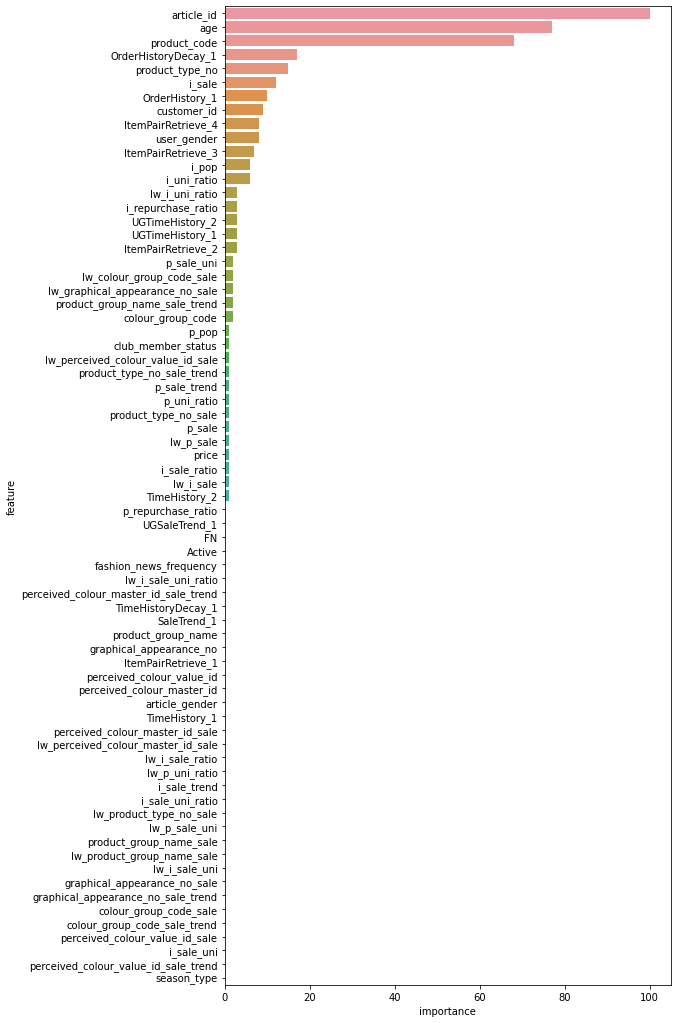

In [48]:
feat_importance = pd.DataFrame(
    {"feature": feats, "importance": ranker.feature_importance()}
).sort_values(by="importance", ascending=False)
plt.figure(figsize=(8, 18))
sns.barplot(y="feature", x="importance", data=feat_importance)

similarity

In [37]:
# ranker = train_model(full_data, 1, 4) # 0.82846 4-week 0.853142
ranker = train_model(full_data, 1, 4)
# 0.703171 -> 0.709413

Validating week: 1
Train positive rate: 0.005362918422285184
Training until validation scores don't improve for 30 rounds.
[10]	valid_0's map@12: 0.797582
[20]	valid_0's map@12: 0.797597
[30]	valid_0's map@12: 0.797907
[40]	valid_0's map@12: 0.798096
[50]	valid_0's map@12: 0.798493
[60]	valid_0's map@12: 0.798776
[70]	valid_0's map@12: 0.798948
[80]	valid_0's map@12: 0.798989
[90]	valid_0's map@12: 0.799075
[100]	valid_0's map@12: 0.79918
[110]	valid_0's map@12: 0.799192
[120]	valid_0's map@12: 0.799187
[130]	valid_0's map@12: 0.799287
[140]	valid_0's map@12: 0.799325
[150]	valid_0's map@12: 0.799313
[160]	valid_0's map@12: 0.799403
[170]	valid_0's map@12: 0.79944
[180]	valid_0's map@12: 0.799454
[190]	valid_0's map@12: 0.799549
[200]	valid_0's map@12: 0.799596
[210]	valid_0's map@12: 0.799581
[220]	valid_0's map@12: 0.799566
[230]	valid_0's map@12: 0.799581
[240]	valid_0's map@12: 0.799666
[250]	valid_0's map@12: 0.799645
[260]	valid_0's map@12: 0.799687
[270]	valid_0's map@12: 0.7997

<Figure size 576x1296 with 0 Axes>

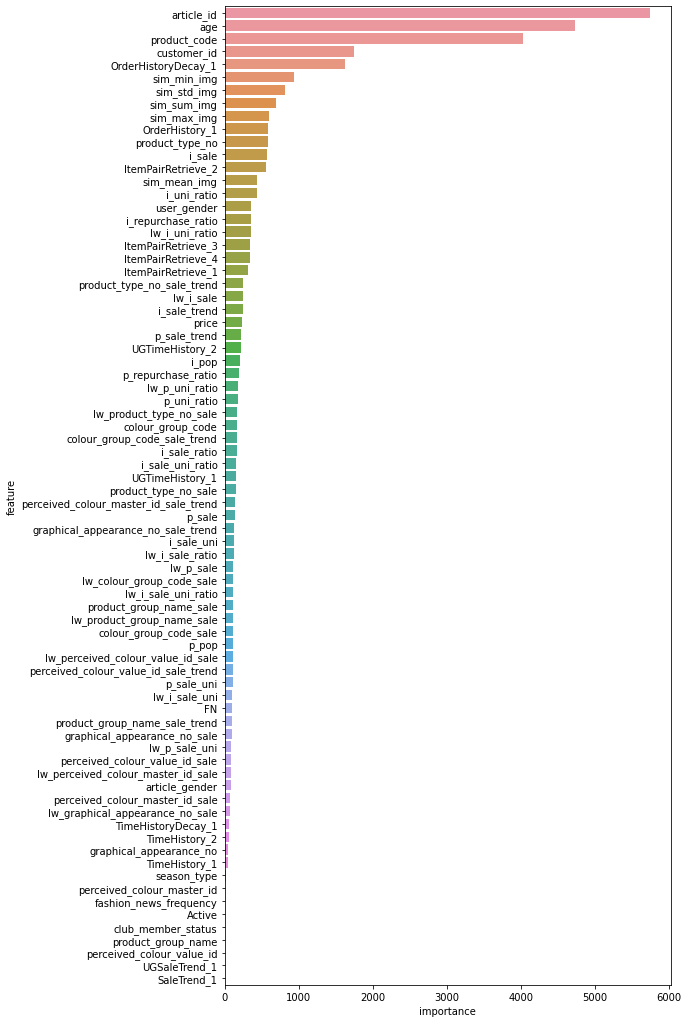

In [38]:
feat_importance = pd.DataFrame(
    {"feature": feats, "importance": ranker.feature_importance()}
).sort_values(by="importance", ascending=False)
plt.figure(figsize=(8, 18))
sns.barplot(y="feature", x="importance", data=feat_importance)

### Inference

In [ ]:
ranker = lgb.Booster(model_file="../src/data/interim/lgb_ranker_with_sim.model")

### Validate

In [39]:
val_candidates = full_data[full_data["week"] == 1].reset_index(drop=True)

In [40]:
def predict(ranker, candidates, batch_size = 5_000_000):
    probs = np.zeros(candidates.shape[0])
    for batch in range(0, candidates.shape[0], batch_size):
        outputs = ranker.predict(candidates.loc[batch : batch + batch_size - 1, feats])
        probs[batch : batch + batch_size] = outputs
    candidates["prob"] = probs
    pred_lgb = candidates[['customer_id','article_id','prob']]
    pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
    pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)
    pred_lgb = pred_lgb.drop_duplicates(['customer_id', 'prediction'], keep='first')
    pred_lgb['customer_id'] = pred_lgb['customer_id'].astype(int)
    pred_lgb = pred_lgb.groupby("customer_id")["prediction"].progress_apply(list).reset_index()
    return pred_lgb

In [49]:
pred = predict(ranker, val_candidates)

100%|██████████| 80093/80093 [00:06<00:00, 13058.95it/s]


In [50]:
label = labels[1]
label = pd.merge(label, pred, on="customer_id", how="left")

baseline

In [51]:
map_at_k(label["article_id"], label["prediction"], k=12)


0.027645591265924453

similarity

In [43]:
map_at_k(label["article_id"], label["prediction"], k=12)

# 0.02820525160663368 1-week add normalization
# 0.028936597823123886 4-week 0.0274
# 0.029111989281461418 4-week drop full-negative customer
# 0.029165419468984943 3-week 0.0270
# 0.028297597743100006 6 week 0.0250

# 0.02863472423766257 4 week
# 0.02882844782917304 4 week
# 0.028909064246733205 4 week
# 0.029366338019601947 4 week

0.029375463664053445

baseline:0.0286
with image similarity:0.0277

### Test

In [ ]:
full_data = pd.concat(candidates[i] for i in range(1, WEEK_NUM))
train_ag = full_data

del full_data

In [ ]:
train_ag = train_ag.sort_values(by=['week', 'customer_id'],ascending=True).reset_index(drop=True)

train_ag_group = train_ag[["customer_id", "article_id", "week"]]
train_ag_group = train_ag_group.astype("int")
train_ag_group = train_ag_group.groupby(["week","customer_id"])['article_id'].count().values

In [ ]:
params = {
    "objective": "lambdarank",
    "boosting_type": "gbdt",
    "metric": "map",
    "max_depth": 8,
    "num_leaves": 128,
    "learning_rate": 0.01,
    "verbose": -1,
    "eval_at": 12,
}

train_ag_set = lgb.Dataset(
    data=train_ag[feats],
    label=train_ag["label"],
    group=train_ag_group,
    feature_name=feats,
    categorical_feature=cat_features,
    params=params,
)

ranker_ag = lgb.train(
    params,
    train_ag_set,
    num_boost_round=121,
    valid_sets=[train_ag_set],
    verbose_eval=10
)

[10]	training's map@12: 0.819237
[20]	training's map@12: 0.820026
[30]	training's map@12: 0.820287
[40]	training's map@12: 0.820511
[50]	training's map@12: 0.820685
[60]	training's map@12: 0.820875
[70]	training's map@12: 0.821112
[80]	training's map@12: 0.821273
[90]	training's map@12: 0.821479
[100]	training's map@12: 0.821656
[110]	training's map@12: 0.821777
[120]	training's map@12: 0.821992


<Figure size 576x864 with 0 Axes>

<AxesSubplot:xlabel='importance', ylabel='feature'>

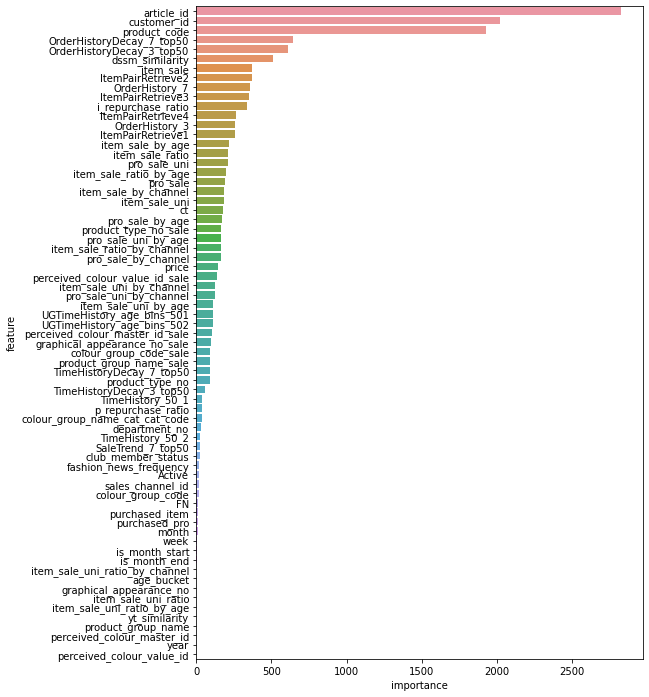

In [ ]:
feat_importance = pd.DataFrame(
    {"feature": feats, "importance": ranker_ag.feature_importance()}
).sort_values(by="importance", ascending=False)
plt.figure(figsize=(8, 12))
sns.barplot(y="feature", x="importance", data=feat_importance)

In [ ]:
ranker_ag.save_model(data_dir / "interim/lgb_ranker_ag.model")

In [ ]:
ranker_ag = lgb.Booster(model_file=data_dir / "interim/lgb_ranker_ag.model")

In [ ]:
test_candidates = candidates[0].reset_index(drop=True)

In [ ]:
test_candidates.columns

Index(['customer_id', 'article_id', 'ItemPairRetrieve1', 'ItemPairRetrieve2',
       'ItemPairRetrieve3', 'ItemPairRetrieve4', 'OrderHistoryDecay_3_top50',
       'OrderHistoryDecay_7_top50', 'OrderHistory_3', 'OrderHistory_7',
       'SaleTrend_7_top4', 'TimeHistoryDecay_3_top31',
       'TimeHistoryDecay_7_top24', 'TimeHistory_25_1', 'TimeHistory_30_2',
       'UGSaleTrend_7_top3', 'UGTimeHistory_age_bins_351',
       'UGTimeHistory_age_bins_38.52', 't_dat', 'price', 'sales_channel_id',
       'product_code', 'week', 'item_sale', 'pro_sale', 'item_sale_uni',
       'pro_sale_uni', 'item_sale_ratio', 'item_sale_uni_ratio',
       'product_type_no_sale', 'product_group_name_sale',
       'graphical_appearance_no_sale', 'colour_group_code_sale',
       'perceived_colour_value_id_sale', 'perceived_colour_master_id_sale',
       'i_repurchase_ratio', 'p_repurchase_ratio', 'purchased_item',
       'purchased_pro', 'FN', 'Active', 'club_member_status',
       'fashion_news_frequency', 'age'

In [ ]:
# As the threshold is set mannually when generating candidates for test set, we need to change the name of the columns
test_candidates.rename(columns = {
    'SaleTrend_7_top4':'SaleTrend_7_top50', 
    'TimeHistoryDecay_3_top31':'TimeHistoryDecay_3_top50',
    'TimeHistoryDecay_7_top24':'TimeHistoryDecay_7_top50',
    'TimeHistory_25_1':'TimeHistory_50_1', 
    'TimeHistory_30_2':'TimeHistory_50_2', 
    'UGSaleTrend_3_top2':'UGSaleTrend_7_top50', 
    'UGTimeHistory_age_bins_351':'UGTimeHistory_age_bins_501',
    'UGTimeHistory_age_bins_38.52':'UGTimeHistory_age_bins_502'
},inplace=True)

In [ ]:
probs = np.zeros(test_candidates.shape[0])
batch_size = 5_000_000
for batch in tqdm(range(0, test_candidates.shape[0], batch_size)):
    outputs = ranker_ag.predict(test_candidates.loc[batch : batch + batch_size - 1, feats])
    probs[batch : batch + batch_size] = outputs

100%|██████████| 20/20 [03:36<00:00, 10.82s/it]


In [ ]:
test_candidates["prob"] = probs

In [ ]:
pred_lgb = test_candidates[['customer_id','article_id','prob']]
pred_lgb = pred_lgb.sort_values(by=["customer_id","prob"], ascending=False).reset_index(drop=True)
pred_lgb.rename(columns={'article_id':'prediction'}, inplace=True)

In [ ]:
idx2uid = pickle.load(open(data_dir/"index_id_map/user_index2id.pkl", "rb"))
idx2iid = pickle.load(open(data_dir/"index_id_map/item_index2id.pkl", "rb"))

In [ ]:
pred_lgb['prediction'] = pred_lgb['prediction'].map(idx2iid).progress_apply(lambda x:'0'+str(x))
pred_lgb = pred_lgb.groupby('customer_id')['prediction'].progress_apply(list).reset_index()
pred_lgb['prediction'] = pred_lgb['prediction'].progress_apply(lambda x: ' '.join(x[:12]))

100%|██████████| 1371980/1371980 [00:02<00:00, 497061.66it/s]


In [ ]:
uid2idx = pickle.load(open(data_dir/"index_id_map/user_id2index.pkl", "rb"))
submission = pd.read_csv(data_dir/"raw"/'sample_submission.csv')
submission['customer_id'] = submission['customer_id'].map(uid2idx)

In [ ]:
del submission['prediction']
submission = submission.merge(pred_lgb, on='customer_id', how='left')
submission['customer_id'] = submission['customer_id'].map(idx2uid)

In [ ]:
submission.to_csv('submission.csv.gz', index=False)

In [ ]:
submission.head()

,customer_id,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,0779781015 0568601043 0858856005 0918522001 09...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,0918522001 0924243001 0918292001 0924243002 09...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0794321007 0805000001 0918522001 0924243001 09...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,0930380001 0918522001 0924243001 0924243002 09...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,0896152001 0791587001 0927530006 0730683050 08...


### Submit

In [ ]:
submit_msg = """
0.029366338019601947 4-week
---
OrderHistory(train, 3),
OrderHistory(train, 7),
OrderHistoryDecay(train, 3, n=50),
OrderHistoryDecay(train, 7, n=50),
ItemPair(OrderHistory(train, 3).retrieve(), name='1'),
ItemPair(OrderHistory(train, 7).retrieve(), name='2'),
ItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),
ItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),
UserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50 if week!=0 else 15, name='1'),
UserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50 if week!=0 else 20.5, name='2'),
UserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=50 if week!=0 else 2),
TimeHistory(customer_list, last_week, n=50 if week!=0 else 9, name='1'),
TimeHistory(customer_list, last_3days, n=50 if week!=0 else 16, name='2'),
TimeHistoryDecay(customer_list, train, 3, n=50 if week!=0 else 12),
TimeHistoryDecay(customer_list, train, 7, n=50 if week!=0 else 8),
SaleTrend(customer_list, train, 7, n=50 if week!=0 else 2)
---
min_pos_rate = 0.005 & cluster articles, groupings on channel & age, age bucket, month, year, 
month start, end, sales channel, removed age
pivot
"""

In [ ]:
submit_msg

"\n0.029366338019601947 4-week\n---\nOrderHistory(train, 3),\nOrderHistory(train, 7),\nOrderHistoryDecay(train, 3, n=50),\nOrderHistoryDecay(train, 7, n=50),\nItemPair(OrderHistory(train, 3).retrieve(), name='1'),\nItemPair(OrderHistory(train, 7).retrieve(), name='2'),\nItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),\nItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),\nUserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50 if week!=0 else 15, name='1'),\nUserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50 if week!=0 else 20.5, name='2'),\nUserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=50 if week!=0 else 2),\nTimeHistory(customer_list, last_week, n=50 if week!=0 else 9, name='1'),\nTimeHistory(customer_list, last_3days, n=50 if week!=0 else 16, name='2'),\nTimeHistoryDecay(customer_list, train, 3, n=50 if week!=0 else 12),\nTimeHistoryDecay(customer_list, train, 7, n=50 if week!=0 else 8),\nSaleTre

In [ ]:
! kaggle competitions submit -c h-and-m-personalized-fashion-recommendations -f "submission.csv.gz" -m '\n0.029111989281461418 4-week drop full negative user\n---\nOrderHistory(train, 3),\nOrderHistory(train, 7),\nOrderHistoryDecay(train, 3, n=50),\nOrderHistoryDecay(train, 7, n=50),\nItemPair(OrderHistory(train, 3).retrieve(), name='1'),\nItemPair(OrderHistory(train, 7).retrieve(), name='2'),\nItemPair(OrderHistoryDecay(train, 3, n=50).retrieve(), name='3'),\nItemPair(OrderHistoryDecay(train, 7, n=50).retrieve(), name='4'),\nUserGroupTimeHistory(data, customer_list, last_week, ['age_bins'], n=50 if week!=0 else 15, name='1'),\nUserGroupTimeHistory(data, customer_list, last_3days, ['age_bins'], n=50 if week!=0 else 20.5, name='2'),\nUserGroupSaleTrend(data, customer_list, train, ['age_bins'], 7, n=50 if week!=0 else 2),\nTimeHistory(customer_list, last_week, n=50 if week!=0 else 9, name='1'),\nTimeHistory(customer_list, last_3days, n=50 if week!=0 else 16, name='2'),\nTimeHistoryDecay(customer_list, train, 3, n=50 if week!=0 else 12),\nTimeHistoryDecay(customer_list, train, 7, n=50 if week!=0 else 8),\nSaleTrend(customer_list, train, 7, n=50 if week!=0 else 2)\n---\nmin_pos_rate = 0.006\npivot\n'


100%|######################################| 66.2M/66.2M [00:03<00:00, 19.3MB/s]
Successfully submitted to H&M Personalized Fashion Recommendations